# Project 6: Generate Fashion images using GANs
# Author: Aqib Aziz
## Install dependencies and data

## Part 1: Generating Images using my Custom GAN (Trained for only 200 epochs just for the purpose of completing the task. Recommended epochs are 2000 or more but it is very time consuming)

In [3]:
!pip install tensorflow matplotlib tensorflow-datasets ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.7 MB/s eta 0:00:00


In [32]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [33]:
ds = tfds.load('fashion_mnist', split='train')

## Visualize and build dataset

In [34]:
import numpy as np

In [35]:
# setting connection with dataset to get images
data_iterator = ds.as_numpy_iterator()

In [36]:
# getting data out of a pipeline
data_iterator.next()

{'image': array([[[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 18],
         [ 77],
         [227],
         [227],
         [208],
         [210],
         [225],
         [216],
         [ 85],
         [ 32],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 61],
         [100],
         [ 97],
         [ 80],
         [ 57],
         [117],
         [227],
         [238],
         [115],
         [ 49],
         [ 78],
         [106],
         [108],
         [ 71],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         

In [37]:
data_iterator.next().keys()

dict_keys(['image', 'label'])

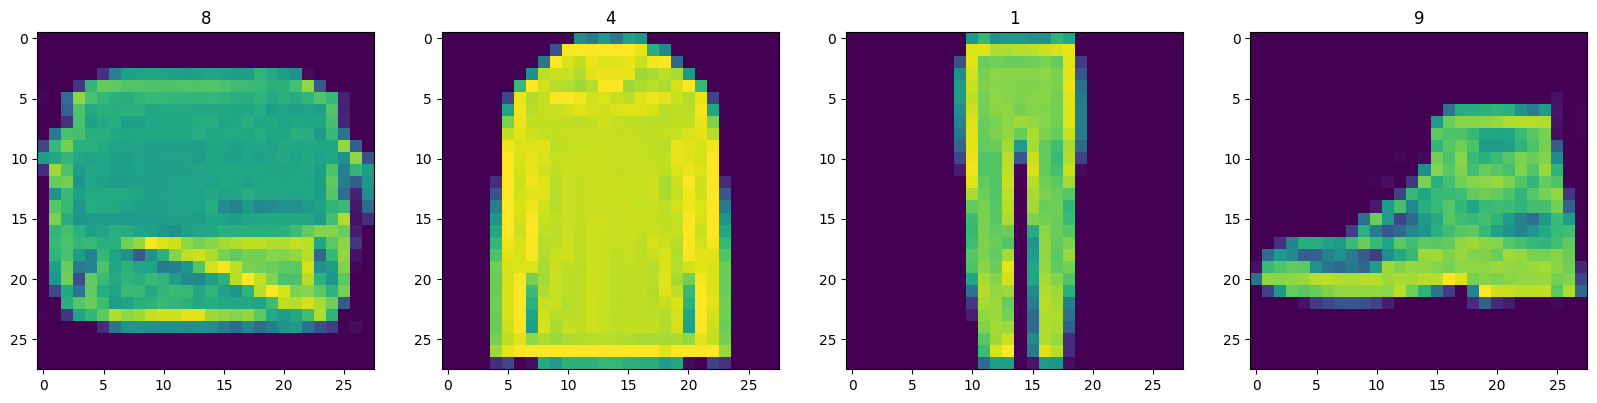

In [38]:
# ploting the data
fig, ax = plt.subplots(ncols=4, figsize = (20, 20))    # ax=subplots in the fig
# getting 4 images
for idx in range(4):
  sample = data_iterator.next()   # grab an image and label
  ax[idx].imshow(np.squeeze(sample['image']))   # plot the image using subplot
  ax[idx].title.set_text(sample['label'])   # appending image label as plot title

In [39]:
ax

array([<Axes: title={'center': '8'}>, <Axes: title={'center': '4'}>,
       <Axes: title={'center': '1'}>, <Axes: title={'center': '9'}>],
      dtype=object)

## Rescaling images

In [40]:
def scale_images(data):
  image = data['image']
  return image/255

In [41]:
ds = tfds.load('fashion_mnist', split='train')  # reload the dataset
ds = ds.map(scale_images)  # runnig the dataset through the scale_images processing step
ds = ds.cache()            # cache the dataset for that batch
ds = ds.shuffle(60000)     # shuffling
ds = ds.batch(128)         # batch into 128 images per sample
ds = ds.prefetch(64)       # reduces the likelihood of bottlenecking

In [42]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

## Building Neural Network

In [43]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

- Build Generator

In [44]:
def build_generator():
  model = Sequential()

  # takes 128 random values and reshape it in to 7x7x128
  model.add(Dense(7*7*128, input_dim= 128))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((7,7,128)))

  # Upsampling block 1
  model.add(UpSampling2D())
  model.add(Conv2D(128, 5, padding = 'same'))
  model.add(LeakyReLU(0.2))

  # Upsampling block 2
  model.add(UpSampling2D())
  model.add(Conv2D(128, 5, padding = 'same'))
  model.add(LeakyReLU(0.2))

  # Convolutional block 1
  model.add(Conv2D(128, 4, padding = 'same'))
  model.add(LeakyReLU(0.2))

  # Convolutional block 2
  model.add(Conv2D(128, 4, padding='same'))
  model.add(LeakyReLU(0.2))

  # Final Conv layer to get to 1 channel
  model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))


  return model


In [45]:
generator = build_generator()

In [46]:
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_2 (UpSampling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                      

In [47]:
img = generator.predict(np.random.randn(4, 128, 1))

1/1 [==============================] - 0s 219ms/step


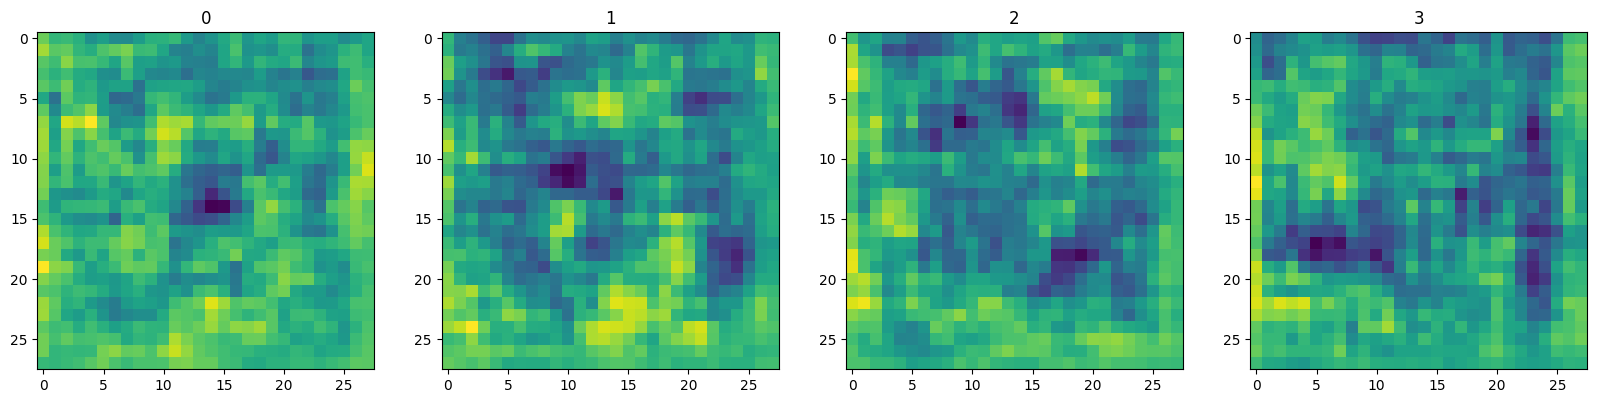

In [48]:
# testing generator
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(img):
  ax[idx].imshow(np.squeeze(img))
  ax[idx].title.set_text(idx)

- Build Descriminator

In [50]:
def build_discriminator():

  model = Sequential()

  # First conv block
  model.add(Conv2D(32, 5, input_shape= (28, 28, 1)))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # Second conv block
  model.add(Conv2D(64,5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # Third conv block
  model.add(Conv2D(128,5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # Fourth conv block
  model.add(Conv2D(128,5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # Flatten then pass to dense layer
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))

  return model

In [51]:
discriminator = build_discriminator()

In [52]:
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_5 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_6 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 16, 16, 128)      

In [53]:
images = generator.predict(np.random.randn(4, 128, 1))
images.shape

1/1 [==============================] - 0s 133ms/step


(4, 28, 28, 1)

In [54]:
# checking discriminator
discriminator.predict(images)


1/1 [==============================] - 0s 99ms/step


array([[0.5011496],
       [0.5010667],
       [0.5009404],
       [0.5010604]], dtype=float32)

## Constructing Training Loop

- Loss and optimizer

In [55]:
# adam optimizer for both (generator and discriminator)
from keras.optimizers import Adam

# binary cross entropy for both (generator and discriminator)
from keras.losses import BinaryCrossentropy

In [56]:
g_opt = Adam(learning_rate = 0.0001)
d_opt = Adam(learning_rate = 0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

- Build Subclassed Model

In [57]:
# Importing the base model class to subclass training step
from keras.models import Model

In [58]:
class FashionGAN(Model):

  def __init__(self, generator, discriminator, *args, **kwargs):

    # pass args and kwargs to base class
    super().__init__(*args, **kwargs)

    # creating attributes for gen and disc
    self.generator = generator
    self.discriminator = discriminator

  def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
    # compile with base class
    super().compile(*args, **kwargs)

    # create attributes for losses and optimizers
    self.g_opt = g_opt
    self.d_opt = d_opt
    self.g_loss = g_loss
    self.d_loss  = d_loss

  def train_step(self, batch):
    # Get the data
    real_images = batch
    fake_images = self.generator(tf.random.normal((128, 128, 1)), training = False)

    # Train the discriminator
    with tf.GradientTape() as d_tape:
      # pass real and fake images to the discriminator
      yhat_real = self.discriminator(real_images, training = True)
      yhat_fake = self.discriminator(fake_images, training = True)
      yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

      # create labels for real and fake images
      y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

      # add some noise to the TRUE outputs
      noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
      noise_fake = - 0.15*tf.random.uniform(tf.shape(yhat_fake))
      y_realfake += tf.concat([noise_real, noise_fake], axis=0)

      # calculating loss
      total_d_loss = self.d_loss(y_realfake, yhat_realfake)

    # apply backpropagation
    dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
    self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

    # Train the generator
    with tf.GradientTape() as g_tape:
      # generate some new images
      gen_images = self.generator(tf.random.normal((128,128,1)), training=True)

      # create the predicted labels
      predicted_labels = self.discriminator(gen_images, training = False)

      # calculate loss - trick to train to fake out the discriminator
      total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

    # Apply backpropagation
    ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
    self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

    return {"g_loss":total_d_loss, "d_loss":total_g_loss}

In [59]:
# create instance of subclass model
fashgan = FashionGAN(generator, discriminator)

In [60]:
# Compile the Model
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

## Build Callback

In [61]:
import os
from tensorflow.keras.preprocessing.image import array_to_img

## Training

In [43]:
hist = fashgan.fit(ds, epochs = 200)

Epoch 1/200
469/469 [==============================] - 68s 145ms/step - g_loss: 0.2974 - d_loss: 0.1309
Epoch 2/200
469/469 [==============================] - 70s 150ms/step - g_loss: 0.2904 - d_loss: 0.1298
Epoch 3/200
469/469 [==============================] - 71s 152ms/step - g_loss: 0.2848 - d_loss: 0.1321
Epoch 4/200
469/469 [==============================] - 72s 153ms/step - g_loss: 0.2828 - d_loss: 0.1424
Epoch 5/200
469/469 [==============================] - 71s 152ms/step - g_loss: 0.2813 - d_loss: 0.1550
Epoch 6/200
469/469 [==============================] - 71s 152ms/step - g_loss: 0.2812 - d_loss: 0.1644
Epoch 7/200
469/469 [==============================] - 71s 152ms/step - g_loss: 0.3313 - d_loss: 1.0077
Epoch 8/200
469/469 [==============================] - 71s 152ms/step - g_loss: 0.2912 - d_loss: 0.3255
Epoch 9/200
469/469 [==============================] - 72s 153ms/step - g_loss: 0.2842 - d_loss: 0.2537
Epoch 10/200
469/469 [==============================] - 72s 153m

## Model Performance

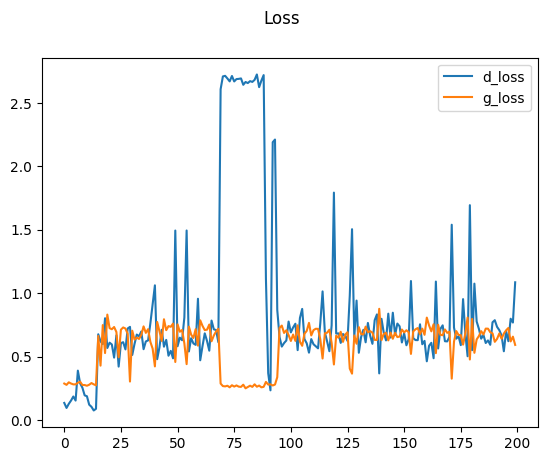

In [44]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

## Testing Generator

In [62]:
imgs = generator.predict(tf.random.normal((9,128,1)))

1/1 [==============================] - 1s 528ms/step


### As the Model is trained for only 200 epochs to save time so the result is very poor. To get better results training for over 2000 or 5000 epochs or even more should be good.

In [64]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(5,5))
for r in range(3):
  for c in range(3):
    ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

## Saving the Model

In [65]:
generator.save('generator.h5')
discriminator.save('discriminator.h5')

--------------------------------------------

# Part 2: Generaing images using pretrained model in PyTorch

- Download the pretrained model

In [74]:
import torch

use_gpu = True if torch.cuda.is_available() else False

model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
                       'DCGAN',
                       pretrained=True,
                       useGPU=use_gpu)

Downloading: "https://github.com/facebookresearch/pytorch_GAN_zoo/zipball/hub" to /root/.cache/torch/hub/hub.zip
Downloading: "https://dl.fbaipublicfiles.com/gan_zoo/DCGAN_fashionGen-1d67302.pth" to /root/.cache/torch/hub/checkpoints/DCGAN_fashionGen-1d67302.pth
100%|██████████| 39.7M/39.7M [00:00<00:00, 153MB/s]


Average network found !


- Feeding 16 random generated inputs to generate 16 Images

In [77]:
num_images = 16
noise, _ = model.buildNoiseData(num_images)

print(noise.shape)

torch.Size([16, 120])


- Generating Images

In [78]:
with torch.no_grad():
    generated_images = model.test(noise)

- Visualizing Images

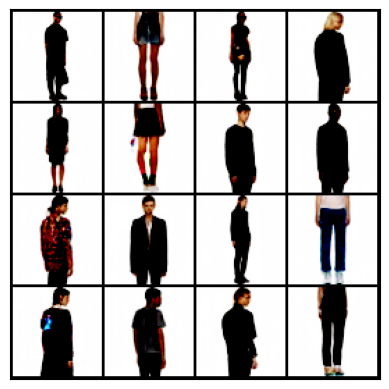

In [84]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

image_grid = make_grid(generated_images, ncol=4, nrow=4) # Make images into a grid
image_grid = image_grid.permute(1, 2, 0)        # Move channel to the last
image_grid = image_grid.cpu().numpy()           # Convert into Numpy

plt.imshow(image_grid)
plt.xticks([])
plt.yticks([])
plt.show()

# END